# Banana Navigation using DQN

---

This notebook builds and trains a DQN agent locally to solve the Banana Navigation problem, using the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

First, we must build the required environment. The instructions to do so are shown here: https://github.com/udacity/deep-reinforcement-learning#dependencies

I had to also update PyTorch version, as I had some issues locally when calling `.to(device)` on PyTorch tensors. Also, as I am training in a computer with an NVIDIA GPU (RTX 2070), I installed CUDA Toolkit. I also installed [PyTorch Summary](https://github.com/sksq96/pytorch-summary) to visualize the model:
```
> conda install pytorch cudatoolkit=10.2 -c pytorch
> pip install torchsummary
```


After setting up the environment, we begin by importing some necessary packages:

In [1]:
from collections import deque
from torchsummary import summary
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# DQN agent to be trained
from dqn_agent import Agent

Next, we will start the environment! The UnityEnvironment file can be downloaded in the following links and is not uploaded to this repository.

- Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip)
- Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip)
- Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86.zip)
- Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip)

In this project, I am working on an Ubuntu 20.04 64 bits, so I installed the Linux version and used the Banana.x86_64 file.

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

The next cell shows how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Training DQN Agent

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def run_episode(agent, train_mode=False, eps=0.01, if_train_then_step=True):
    """Runs a single episode of the environment.

    Params
    ======
        agent (Agent): agent object to be trained
        train_mode (bool): train_mode to be passed to the environment
        eps (float): epsilon value to be used in epsilon-greedy approach by the agent
        if_train_then_step (bool): indicates if agent should be trained when train_mode=True
    """    
    env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps)                 # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        if train_mode and if_train_then_step:
            agent.step(state, action, reward, next_state, done) # step in the agent model
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    return score

In [7]:
def dqn(agent, n_episodes=2000, eps_start=1.0, eps_end=0.01,
        eps_decay=0.9977, checkpoint_each=500, print_each=100,
        solve_window_size=100, solve_score=13, scale_eps=True):
    """Trains a DQN agent.

    Params
    ======
        agent (Agent): agent object to be trained
        n_episodes (int): number of episodes
        eps_start (float): initial epsilon value
        eps_end (float): minimum epsilon value
        eps_decay (float): epsilon multiplier after each episode
        checkpoint_each (int): number of episodes to skip before checkpointing model 
        print_each (int): number of episodes to skip before printing current score
        solve_window_size (int): number of consecutive episodes to consider the environment solved
        solve_score (int): minimum average score to reach after solve_window_size
        scale_eps (bool): indicates if eps_decay should be scaled so that
                          last ~20% last epsilon values get equal to eps_end
    """
    if scale_eps:
        eps_decay = 0.9977**(2500/n_episodes)
        
    eps = eps_start
    scores = []
    scores_window = deque(maxlen=solve_window_size)
    
    for i in range(1, n_episodes+1):
        score = run_episode(agent, train_mode=True, eps=eps)
        scores.append(score)
        scores_window.append(score)
        eps = max(eps_end, eps_decay*eps)
        avg_score = np.mean(scores_window)
        if i%print_each == 0 or avg_score >= solve_score:
            print("[{:4d}/{:4d}]  |  "
                  "Score: {:+3.0f}  |  "
                  "Avg. Score: {:+6.2f}  |  "
                  "epsilon: {:.3f}".format(i, n_episodes, score, avg_score, eps)
            )
        if i%checkpoint_each == 0:
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pt')
            print('Checkpoint saved!')
        if avg_score >= solve_score:
            print('Environment solved in {} episodes!'.format(i))
            break
            
    # save model after all episodes
    torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
    print('Model saved!')
    
    if np.mean(scores_window) < solve_score:
        print('Agent could not solve the environment in {} episodes'.format(n_episodes))
        
    return scores

Create agent and display its network architecture (both local and target networks have the same architecture):

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
print('Agent network architecture:')
summary(agent.qnetwork_local, (state_size,))

Agent network architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,432
       BatchNorm1d-2                   [-1, 64]             128
             PReLU-3                   [-1, 64]               1
            Linear-4                   [-1, 64]           4,160
       BatchNorm1d-5                   [-1, 64]             128
             PReLU-6                   [-1, 64]               1
            Linear-7                    [-1, 4]             260
Total params: 7,110
Trainable params: 7,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [9]:
all_scores = []

In [10]:
%%time
scores = dqn(agent)
all_scores += scores

[ 100/2000]  |  Score:  +2  |  Avg. Score:  +0.12  |  epsilon: 0.750
[ 200/2000]  |  Score:  +3  |  Avg. Score:  +1.71  |  epsilon: 0.562
[ 300/2000]  |  Score:  +3  |  Avg. Score:  +4.05  |  epsilon: 0.422
[ 400/2000]  |  Score:  +7  |  Avg. Score:  +5.96  |  epsilon: 0.316
[ 500/2000]  |  Score:  +5  |  Avg. Score:  +8.35  |  epsilon: 0.237
Checkpoint saved!
[ 600/2000]  |  Score: +10  |  Avg. Score: +10.06  |  epsilon: 0.178
[ 700/2000]  |  Score:  +7  |  Avg. Score: +11.76  |  epsilon: 0.133
[ 800/2000]  |  Score: +16  |  Avg. Score: +12.89  |  epsilon: 0.100
[ 848/2000]  |  Score: +17  |  Avg. Score: +13.06  |  epsilon: 0.087
Environment solved in 848 episodes!
Model saved!
CPU times: user 20min 39s, sys: 1min 9s, total: 21min 49s
Wall time: 31min 57s


Visualize scores during training process:

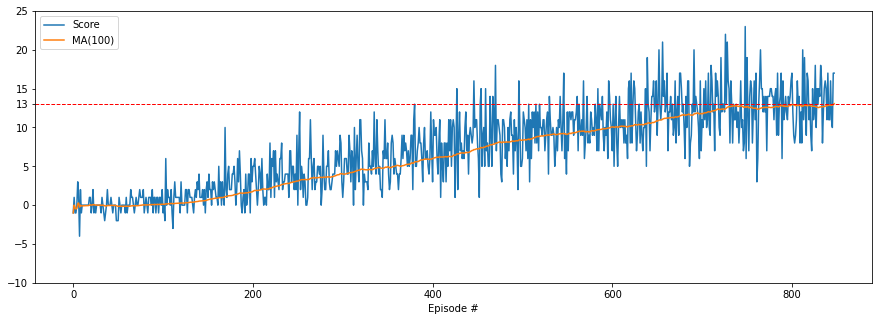

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(all_scores, label='Score')
pd.Series(all_scores).rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
ax.axhline(13, ls='--', lw=1, c='red')
ax.set_xlabel('Episode #')
plt.yticks(list(plt.yticks()[0]) + [13])
ax.legend(loc='upper left');

### 5. Loading and executing DQN Agent

As the model weights are saved, we can load them into a new agent.

In [12]:
trained_agent = Agent(state_size=state_size, action_size=action_size, seed=0)
trained_agent.qnetwork_local.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [13]:
run_episode(trained_agent)

15.0

When finished, you can close the environment.

In [14]:
env.close()